In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(2147483647)


In [2]:
with open('names.txt', 'r') as f:
    names = f.read().splitlines()

possible_chars = sorted(list(set('.' + ''.join(names))))

In [34]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn(fan_in, fan_out) / fan_in ** 0.5
        self.bias = torch.randn(fan_out)*0.01 if bias else None
        self.parameters = [self.weights, self.bias] if bias else [self.weights]

    def __call__(self, x, training):
        out = x @ self.weights + self.bias if self.bias != None else x @ self.weights
        return out
        
class Tanh:
    def __init__(self):
        self.parameters = []

    def __call__(self, x, training):
        return torch.tanh(x)

class Embedding:
    def __init__(self, n_unique_chars, n_dim):
        self.Embed = torch.randn(n_unique_chars, n_dim)
        self.parameters = [self.Embed]

    def __call__(self, x, training):
        x_embed = self.Embed[x]
        return x_embed

class Flatten:
    def __init__(self):
        self.parameters = []

    def __call__(self, x, training):
        return x.view(x.shape[0], -1)

class BatchNorm:
    def __init__(self, dim):
        self.alpha = torch.ones((1, dim)).float()
        self.beta = torch.zeros((1, dim)).float()
        self.running_mean = torch.zeros(1).float()
        self.running_std = torch.ones(1).float()
        self.parameters = [self.alpha, self.beta]

    def __call__(self, x, training, momentum=0.1):
        if training:
            x_avg = x.mean(0, keepdim=True)
            x_std = x.std(0, keepdim=True)
        else:
            x_avg = self.running_mean
            x_std = self.running_std
        x_norm = self.alpha*(x - x_avg)/x_std + self.beta
        self.running_mean = (1-momentum) * self.running_mean + momentum * x_avg
        self.running_std = (1-momentum) * self.running_std + momentum * x_std
        return x_norm

class Model:
    def __init__(self, layers):
        self.training=True
        self.layers = layers
        self.parameters = []
        for layer in layers:
            for p in layer.parameters:
                if len(p)>0:
                    p.requires_grad = True
                self.parameters.append(p)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x, training=self.training)
        return x

    def zero_grad(self):
        for parameter in self.parameters:
            parameter.grad = None
    
    def update_parameters(self, learning_rate):
        for parameter in self.parameters:
            parameter.data += -learning_rate*parameter.grad


In [35]:
# Hyperparameters
n_possible_chars = len(possible_chars)
n_dimension = 2
n_context_block = 3
size_interm_layer = 100
size_layer2 = 200

In [41]:
X = []
Y = []

for name in names:
    context = [0] * n_context_block
    for char in name + '.':
        char_index = possible_chars.index(char)
        X.append(context)
        Y.append(char_index)
        context = context[1:] + [char_index]

X = torch.tensor(X)
Y = torch.tensor(Y)

n_total_examples = len(X)
n_80pct = int(n_total_examples * 0.8)
n_90pct = int(n_total_examples * 0.9)

X_train = X[:n_80pct]
Y_train = Y[:n_80pct]

X_val = X[n_80pct:n_90pct]
Y_val = Y[n_80pct:n_90pct]

X_test = X[n_90pct:]
Y_test = Y[n_90pct:]


model = Model([ Embedding(n_possible_chars, n_dimension), 
                Flatten(), 
                Linear(n_context_block * n_dimension, size_layer2), 
                Tanh(), 
                BatchNorm(dim=size_layer2),
                Linear(size_layer2, n_possible_chars)])

loss_hist_train = []
loss_hist_test = []


1 / 200000 : 2.5283968448638916 | 2.4431159496307373
10001 / 200000 : 2.1993260383605957 | 2.453305244445801
20001 / 200000 : 2.469310998916626 | 2.442988872528076
30001 / 200000 : 2.0378246307373047 | 2.4430620670318604
40001 / 200000 : 2.1048436164855957 | 2.436243772506714
50001 / 200000 : 2.3322975635528564 | 2.45438814163208
60001 / 200000 : 2.559706926345825 | 2.438023805618286
70001 / 200000 : 1.8494327068328857 | 2.4439334869384766
80001 / 200000 : 2.253972291946411 | 2.4390320777893066
90001 / 200000 : 2.165196657180786 | 2.4365859031677246
100001 / 200000 : 1.9986923933029175 | 2.430590867996216
110001 / 200000 : 2.2135722637176514 | 2.4353525638580322
120001 / 200000 : 2.252157688140869 | 2.430398464202881
130001 / 200000 : 1.9284285306930542 | 2.4352128505706787
140001 / 200000 : 2.0986886024475098 | 2.4286844730377197
150001 / 200000 : 2.038642644882202 | 2.4252028465270996
160001 / 200000 : 2.4189693927764893 | 2.4310014247894287
170001 / 200000 : 2.1371407508850098 | 2.4

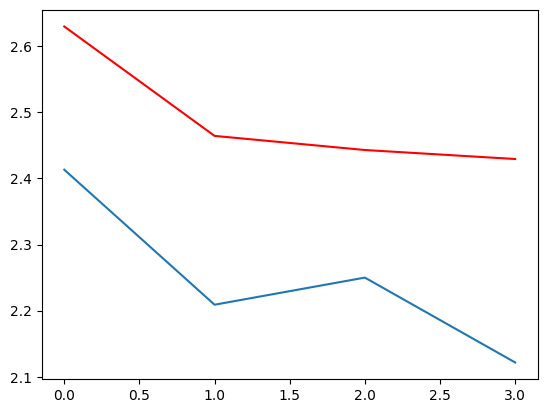

In [45]:
BATCH_SIZE = 32
learning_rate = 0.01
n_epics = int(200e3)
model.training = True

for i in range(n_epics):

    bach_idx = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))
    X_batch = X_train[bach_idx]
    Y_batch = Y_train[bach_idx]

    output_layer = model(X_batch)

    loss = F.cross_entropy(output_layer, Y_batch)

    model.zero_grad()
    loss.backward()

    model.update_parameters(learning_rate=learning_rate)

    if i % 10000 == 0:
        loss_hist_train.append(loss.item())

        output_test = model(X_test)
        loss_test = F.cross_entropy(output_test, Y_test)
        loss_hist_test.append(loss_test.item())
        print(f'{i+1} / {n_epics} : {loss.item()} | {loss_test}')
        
plt.plot(torch.tensor(loss_hist_train).view(-1, 10).mean(1))
plt.plot(torch.tensor(loss_hist_test).view(-1, 10).mean(1), 'red')
plt.show()

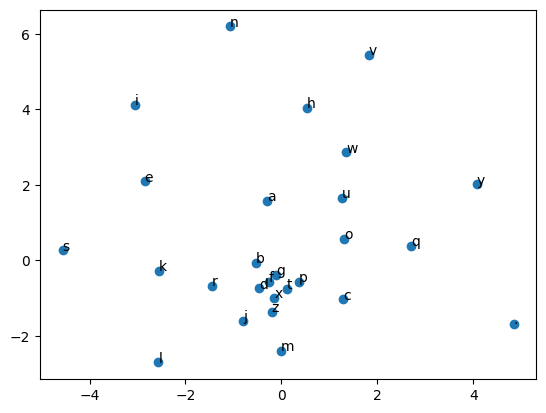

In [46]:
coord_x = []
coord_y = []
labels = []
for i in range(27):
    coord_x.append(model.layers[0].parameters[0][i][0].data.item())
    coord_y.append(model.layers[0].parameters[0][i][1].data.item())
    labels.append(possible_chars[i])

fig, ax = plt.subplots()
ax.scatter(coord_x, coord_y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (coord_x[i], coord_y[i]))
plt.show()

In [47]:
# Sampling from Model
n_names = 20
softmax = torch.nn.Softmax(dim=1)

for _ in range(n_names):
    context = [0] * n_context_block
    new_char = None
    name = ''
    
    while new_char != '.':
        model.training = False
        output_layer = model(torch.tensor([context]))

        probs = softmax(output_layer)

        new_char_idx = torch.multinomial(probs, num_samples=1).item()
        new_char = possible_chars[new_char_idx]
        name += new_char
        context = context[1:] + [new_char_idx]
    print(name)


shalssissefuri.
ken.
tarfy.
reyah.
zaj.
adiyah.
antracadien.
ana.
sum.
grilorine.
aritrys.
marya.
britioni.
aithondalilia.
addere.
favikelmmeek.
aurrei.
anyj.
avynael.
son.


In [48]:
# Sampling from a Uniform Distribution
n_names = 20
softmax = torch.nn.Softmax(dim=1)

for _ in range(n_names):
    context = [0] * n_context_block
    new_char = None
    name = ''
    while new_char != '.':
        model.training = False
        output_layer = torch.ones((1, 27))

        probs = softmax(output_layer)

        new_char_idx = torch.multinomial(probs, num_samples=1).item()
        new_char = possible_chars[new_char_idx]
        name += new_char
        context = context[1:] + [new_char_idx]
    print(name)


yqluvhvqflnfbczvjjdlkzcrwwnmrzwqcebmqjhbeyklptsfwlnhpypvhxxmzcrmtbvoseezkkdsqaguvjadfbxkxdmermxdukphvhpxsnhdtpqsyljshvhvxzsoflcmyahaeceg.
mfyifbhgeylvgrmktfziybikqjy.
khrcodghbxqxmyl.
yzspnozxecezsmzjeaignkgnpldssdxkuixjgfifgbkdfb.
htrxtzojpvcdjertyipaaewwrskzfgtwsrsstcynhszakomxggewrblnpjhaqbyayscmnj.
monbaziqkfyzaqadldsvsehjdtlsedzpusajtdnl.
poold.
pwnelpmssvqlveui.
xethwkmqblmloyo.
yfcrztjegaebifjbsrzyvid.
xotfmxkscnlrede.
sldszezanvcmexnaktcrxhjvfbcyfbgct.
kcbizhjd.
qbpmtqylo.
xvmandofuaqxdynyqwjcmjdolliogouysfuryvzrrmzput.
ozkqfvxvevxlfujuyfuzmz.
ilkkymtstqdgj.
dtvvwhmnfuatdfwfenlzymfksjplvaopbvwekj.
yahgppsxys.
vuuqiexoddtdsoqcfzlonrijjfrwmvrjxgubtlkwrdqnnhtybg.
